In [2]:
#Import des biblothèques utiles

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.linalg as la
from time import process_time
from Parameters import *
from Hydrogen import *
from Field import *
from matplotlib.animation import FuncAnimation

In [3]:
## Définition du solveur de Crank-Nicolson

class CrankNicolson:

    
    def set_grid(self, x_min, x_max, n_x, t_min, t_max, n_t):

        self.x_min, self.x_max, self.n_x = x_min, x_max, n_x
        self.t_min, self.t_max, self.n_t = t_min, t_max, n_t
        self.x_pts, self.delta_x = np.linspace(x_min, x_max, n_x, retstep=True, endpoint=False)
        self.t_pts, self.delta_t = np.linspace(t_min, t_max, n_t, retstep=True, endpoint=False)
        
    def set_parameters(self, f):
        
        self.f = f

    def solve(self, psi_init, sparse=True, boundary_conditions=('dirichlet','dirichlet')):
            
        sig = (1j * self.delta_t) / (4 * self.delta_x**2)
        
        
        # Figure the data type
        data_type = type(sig*psi_init[0])
        
        self.psi_matrix = np.zeros([self.n_t, self.n_x], dtype=data_type)

        # Using sparse matrices and specialized tridiagonal solver speeds up the calculations
        if sparse:
            
            A = self._fillA_sp(sig, self.n_x, data_type)
            B = self._fillB_sp(sig, self.n_x, data_type)
            # Set boundary conditions
            for b in [0,1]:
                if boundary_conditions[b] == 'dirichlet':
                    # u(x,t) = 0
                    A[1,-b] = 1.0
                    A[2*b,1-3*b] = 0.0
                    B[-b,-b] = 0.0
                    B[-b,1-3*b] = 0.0
                elif boundary_conditions[b] == 'neumann':
                    # u'(x,t) = 0
                    A[2*b,1-3*b] = -2*sig
                    B[-b,1-3*b] = 2*sig
                    
            # Propagate
            psi = psi_init
            for n in range(self.n_t):
                t = self.t_min + n*self.delta_t
                self.psi_matrix[n,:] = psi
                fpsi = self.f(psi,t)
                if n==0: fpsi_old = fpsi
                psi = la.solve_banded((1,1),A, B.dot(psi) - 1j*self.delta_t * (1.5 * fpsi - 0.5 * fpsi_old),\
                                    check_finite=False)
                fpsi_old = fpsi

        else:
            
            A = self._make_tridiag(sig, self.n_x, data_type)
            B = self._make_tridiag(-sig, self.n_x, data_type)

            # Set boundary conditions
            for b in [0,1]:
                if boundary_conditions[b] == 'dirichlet':
                    # u(x,t) = 0
                    A[-b,-b] = 1.0
                    A[-b,1-3*b] = 0.0
                    B[-b,-b] = 0.0
                    B[-b,1-3*b] = 0.0
                
                elif boundary_conditions[b] == 'neumann':
                    # u'(x,t) = 0
                    A[-b,1-3*b] = -2*sig
                    B[-b,1-3*b] = 2*sig

            # Propagate
            psi = psi_init
            for n in range(self.n_t):
                self.psi_matrix[n,:] = psi
                fpsi = self.f(psi,t)
                if n==0: fpsi_old = fpsi
                psi = la.solve(A, B.dot(psi) - 1j*self.delta_t * (1.5 * fpsi - 0.5 * fpsi_old))
                fpsi_old = fpsi
            
    def get_final_psi(self):
        
        return self.psi_matrix[-1,:].copy()
        
    def _make_tridiag(self, sig, n, data_type):
    
        M = np.diagflat(np.full(n, (1+2*sig), dtype=data_type)) + \
            np.diagflat(np.full(n-1, -(sig), dtype=data_type), 1) + \
            np.diagflat(np.full(n-1, -(sig), dtype=data_type), -1)

        return M
    
    def _fillA_sp(self, sig, n, data_type):
        """Returns a tridiagonal matrix in compact form ab[1+i-j,j]=a[i,j]"""
        
        A = np.zeros([3,n], dtype=data_type) # A has three diagonals and size n
        A[0] = -(sig) # superdiagonal
        A[1] = 1+2*sig # diagonal
        A[2] = -(sig) # subdiagonal
        return A

    def _fillB_sp(self, sig, n, data_type):
        """Returns a tridiagonal sparse matrix in csr-form"""
        
        _o = np.ones(n, dtype=data_type)
        supdiag = (sig)*_o[:-1]
        diag = (1-2*sig)*_o
        subdiag = (sig)*_o[:-1]
        return scipy.sparse.diags([supdiag, diag, subdiag], [1,0,-1], (n,n), format="csr")

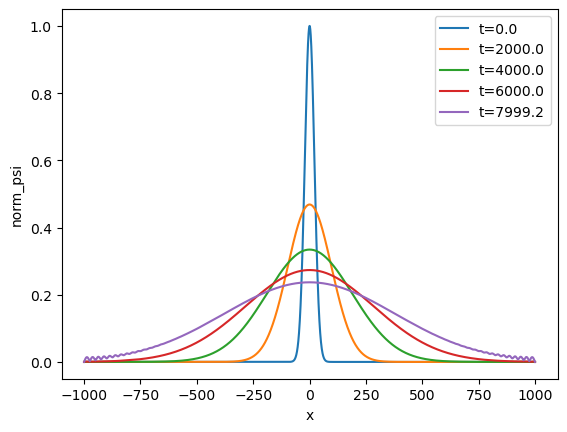

In [4]:
## Etalement d'un paquet d'onde gaussien sans potentiel ni laser
"""

Procedure:
    1. Set up the spatial and time grids.
    2. Initialize the Crank-Nicolson solver with the grid parameters.
    3. Define the initial wave function using a Gaussian.
    4. Solve the TDSE using the Crank-Nicolson method.
    5. Plot the norm of the wave function at specified times.
"""


def gaussian(x, x0, sigma, U_0):
    return U_0 * np.exp(-(x-x0)**2/(sigma**2))

# Those will not change
x_min, x_max, nx = -1000, 1000., 4000
t_min, t_max, nt = 0, 8000., 10000

# Construct the general Crank-Nicolson solver
crank = CrankNicolson()
crank.set_grid(x_min, x_max, nx, t_min, t_max, nt)
X = crank.x_pts

def f(u,t):
    return 0.0

crank.set_parameters(f)
psi_init = gaussian(crank.x_pts, 0, 30, 1)

crank.solve(psi_init, sparse=True)
times_to_plot = [0, int(nt/4), int(nt/2), int(3*nt/4), nt-1]
for t in times_to_plot:
    plt.plot(X, np.abs(crank.psi_matrix[t,:]), label=f't={t*crank.delta_t:.1f}')
plt.xlabel('x')
plt.ylabel('norm_psi')
plt.legend()
plt.show()

In [25]:
## Test 1 : pour un champ laser simple et un potential simple

#Def du champ laser simple
param_single_pulse = pars_YanPengPhysRevA_78_033821()[0]
Field_single_pulse = Field.Pulse(param_single_pulse)
def Field_test(t):
    return Field_single_pulse(t,'Real')

#Def du potentiel 
atom = Hydrogen() 
def Potentiel_test(x):
    return atom.potential(x, 1e-1)

# Those will not change 
l = ((1/(2*Field_single_pulse.w))**2)*0.5*Field_single_pulse.a
x_min, x_max, nx = -10*l, 10*l, 600
t_min, t_max, nt = -10, 10., 200

# Construct the general Crank-Nicolson solver
crank = CrankNicolson()
crank.set_grid(x_min, x_max, nx, t_min, t_max, nt)
X = crank.x_pts

def f(psi,t):
    return Potentiel_test(X)*psi - X*psi*Field_test(t)

crank.set_parameters(f)

psi_init = atom.ground_state_wavefunction(X)
#psi_init = gaussian(crank.x_pts, 0, 30, 1)

crank.solve(psi_init, sparse=True)


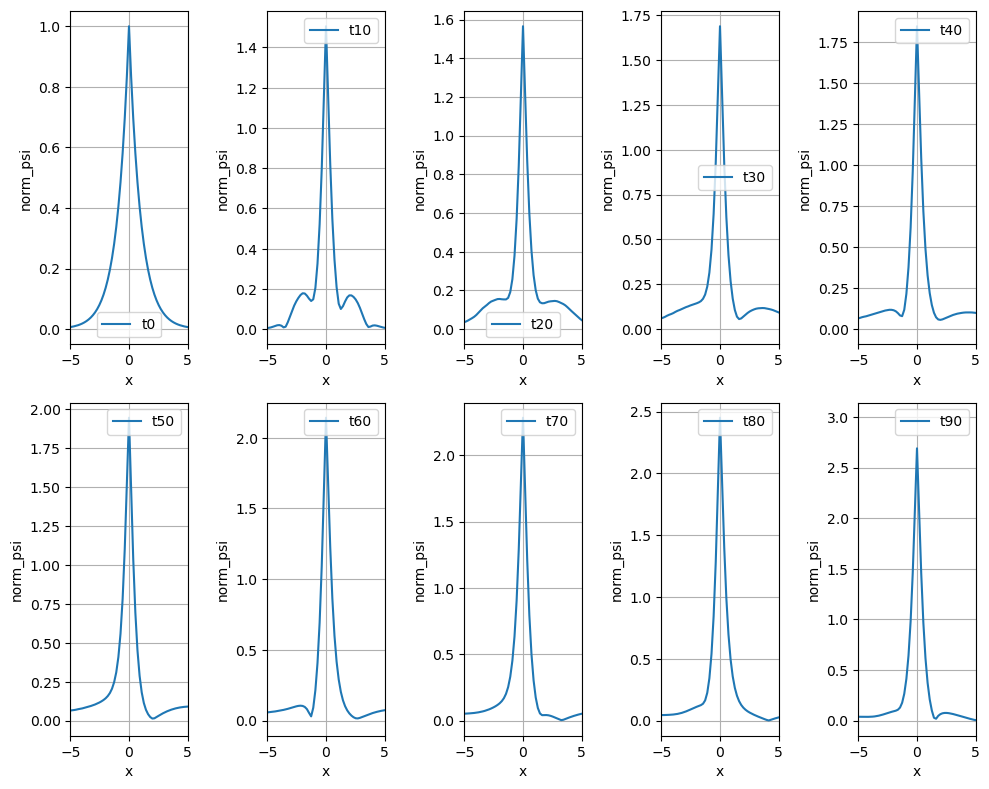

In [26]:
## Test 1 : résultats

# Créer une figure avec une disposition de 2 lignes et 2 colonnes
fig, axs = plt.subplots(2, 5, figsize=(10, 8))

# Parcourir chaque sous-graphe

# Liste des temps et des indices correspondants pour 10 valeurs de temps
times = np.arange(0, 99, 10)
labels = ['t{}'.format(k*10) for k in range(10)]

for ax, t, label in zip(axs.flat, times, labels):
    ax.plot(X, np.abs(crank.psi_matrix[t,:]), label=label)
    ax.set_xlabel('x')
    ax.set_ylabel('norm_psi')
    ax.set_xlim(-5, 5)  # Set x-axis limits
    ax.grid()
    ax.legend()

# Ajuster la disposition
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


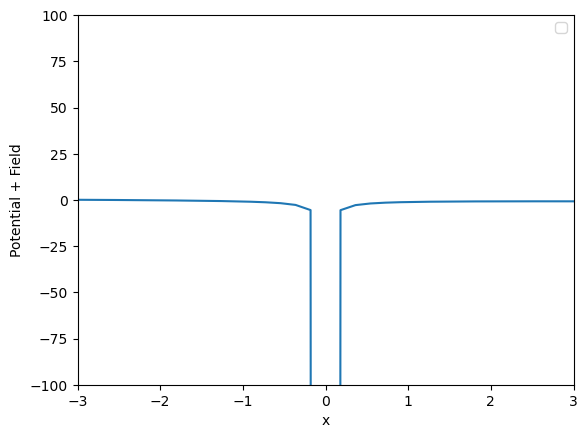

In [113]:
## Test 1 : Affichage de l'évolution du potentiel total ressenti en fonction du temps

# Function to calculate the total potential matrix over time
def potential_total_matrix():
    M = np.zeros([nt, nx])  # Initialize the matrix to store potential values
    for k in range(nt):
        # Calculate the total potential at each time step
        M[k, :] = Potentiel_test(X) - X * Field_test(t_min + k * crank.delta_t)
    return M

# Generate the potential matrix
M = potential_total_matrix()

# Plot the potential at a specific time step
plt.figure()
plt.plot(X, M[100, :])  # Plot the potential at time step 100
plt.xlim(-3, 3)  
plt.ylim(-100, 100)  
plt.xlabel('x')  
plt.ylabel('Potential + Field')  
plt.legend()
plt.show()

(-10.0, 10.0)

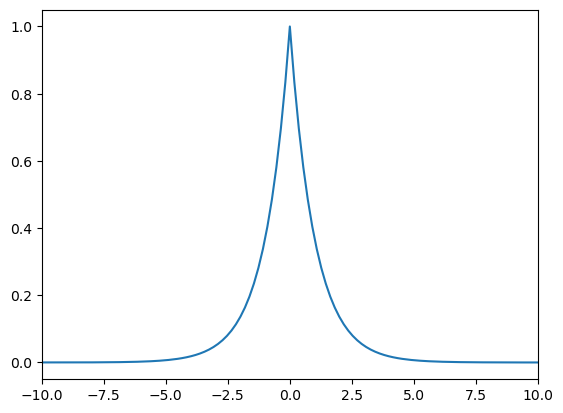

In [8]:
plt.figure()
plt.plot(X,psi_init)
plt.xlim(-10,10)
